# Introduction

#### Imports

Imports and settings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from impyute.imputation.cs import fast_knn

pd.options.mode.chained_assignment = None

# Table of Content

1. [Summary information](#summ)
2. [Data preprocessing](#prep)
3. [Exploratory data analysis](#eda)
4. [Feature selection](#feat)
5. [Prediction](#pred)
6. [Evaluation](#eval)

## 1. Summary information
<a id="summ"></a>

In [162]:
train = pd.read_csv('datasets/train_set.csv')
test = pd.read_csv('datasets/test_set.csv')

In [163]:
train.head(2)

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
0,9.767406e+10,134520.0,70.0,2.0,1199.0,77.0,4.0,861.0,17.550,81.64,18.0,0
1,9.768889e+10,133876.0,67.0,3.0,12585.0,90.0,4.0,4371.0,17.383,189.38,28.0,4


In [164]:
test.head(2)

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent
0,14942256073,122750.0,58.0,2.0,11503.0,89.0,0.0,168.0,13.500,90.19,32.0
1,16036037903,28134.0,68.0,4.0,938.0,81.0,5.0,735.0,13.667,98.27,19.0


In [165]:
print('Number train entries:', len(train), ', Number test entries:', len(test))

Number train entries: 396487 , Number test entries: 132162


In [166]:
train_columns = ['hotel_id', 'city_id', 'content_score', 'n_images', 'distnace_to_center', 'avg_rating', 'stars', 'n_reviews', 'avg_rank', 'avg_price', 'avg_saving_percent', 'n_clicks']

In [167]:
print('train column names and types:', train.dtypes, sep='\n')
print('-'*28)
print('test column names and types:', test.dtypes, sep='\n')

train column names and types:
hotel_id              float64
city_id               float64
content_score         float64
n_images              float64
distance_to_center    float64
avg_rating            float64
stars                 float64
n_reviews             float64
avg_rank              float64
avg_price             float64
avg_saving_percent    float64
n_clicks                int64
dtype: object
----------------------------
test column names and types:
hotel_id                int64
city_id               float64
content_score         float64
n_images              float64
distance_to_center    float64
avg_rating            float64
stars                 float64
n_reviews             float64
avg_rank              float64
avg_price             float64
avg_saving_percent    float64
dtype: object


In [168]:
print('Train data set:  \n\n{0}\n'.format(train.count()))
print('-'*28)
print('Test data set:  \n\n{0}\n'.format(test.count()))

Train data set:  

hotel_id              396487
city_id               395979
content_score         395979
n_images              395978
distance_to_center    395958
avg_rating            286089
stars                 395925
n_reviews             395958
avg_rank              396487
avg_price             396317
avg_saving_percent    396317
n_clicks              396487
dtype: int64

----------------------------
Test data set:  

hotel_id              132162
city_id               132007
content_score         132007
n_images              132006
distance_to_center    131999
avg_rating             95532
stars                 131987
n_reviews             131999
avg_rank              132162
avg_price             132104
avg_saving_percent    132104
dtype: int64



In [169]:
train_columns = list(train.columns)
print('Train data set:\n')
for column in train_columns:
    print('All entries in train set have non-null', column ,':', ~train[column].isnull().any())
    
print('-'*100)

test_columns = list(test.columns)
print('Test data set:\n')
for column in test_columns:
    print('All entries in test set have non-null', column ,':', ~test[column].isnull().any())

Train data set:

All entries in train set have non-null hotel_id : True
All entries in train set have non-null city_id : False
All entries in train set have non-null content_score : False
All entries in train set have non-null n_images : False
All entries in train set have non-null distance_to_center : False
All entries in train set have non-null avg_rating : False
All entries in train set have non-null stars : False
All entries in train set have non-null n_reviews : False
All entries in train set have non-null avg_rank : True
All entries in train set have non-null avg_price : False
All entries in train set have non-null avg_saving_percent : False
All entries in train set have non-null n_clicks : True
----------------------------------------------------------------------------------------------------
Test data set:

All entries in test set have non-null hotel_id : True
All entries in test set have non-null city_id : False
All entries in test set have non-null content_score : False
All 

In [170]:
print("Train data set:\n")
for column in train_columns:
    print('Percentage of missing values for feature', column ,':', round((train[column].isnull().sum()/len(train))*100, 2), '%')
print("-"*100)
print("Test data set:\n")
for column in test_columns:
    print('Percentage of missing values for feature', column ,':', round((test[column].isnull().sum()/len(test))*100, 2), '%')

Train data set:

Percentage of missing values for feature hotel_id : 0.0 %
Percentage of missing values for feature city_id : 0.13 %
Percentage of missing values for feature content_score : 0.13 %
Percentage of missing values for feature n_images : 0.13 %
Percentage of missing values for feature distance_to_center : 0.13 %
Percentage of missing values for feature avg_rating : 27.84 %
Percentage of missing values for feature stars : 0.14 %
Percentage of missing values for feature n_reviews : 0.13 %
Percentage of missing values for feature avg_rank : 0.0 %
Percentage of missing values for feature avg_price : 0.04 %
Percentage of missing values for feature avg_saving_percent : 0.04 %
Percentage of missing values for feature n_clicks : 0.0 %
----------------------------------------------------------------------------------------------------
Test data set:

Percentage of missing values for feature hotel_id : 0.0 %
Percentage of missing values for feature city_id : 0.12 %
Percentage of missi

Globally, there are few missing values per feature. However, the feature **avg_rating** has a big proportion of missing values for both train and test set.

## 2. Data preprocessing
<a id="prep"></a>

Before I do the exploratory data analysis, I want to clean my data set with the following approach :

1. Missing values analysis
2. Outliers detection and removal
3. Missing values imputation

### 2.1. Missing values

In [171]:
train = train.dropna(subset=['city_id', 'content_score', 'n_images', 'distance_to_center', 'stars', 'n_reviews', 'avg_price', 'avg_saving_percent'])
test = test.dropna(subset=['city_id', 'content_score', 'n_images', 'distance_to_center', 'stars', 'n_reviews', 'avg_price', 'avg_saving_percent'])

In [172]:
print("Train data set:\n")
for column in train_columns:
    print('Percentage of missing values for feature', column ,':', round((train[column].isnull().sum()/len(train))*100, 2), '%')
print("-"*100)
print("Test data set:\n")
for column in test_columns:
    print('Percentage of missing values for feature', column ,':', round((test[column].isnull().sum()/len(test))*100, 2), '%')

Train data set:

Percentage of missing values for feature hotel_id : 0.0 %
Percentage of missing values for feature city_id : 0.0 %
Percentage of missing values for feature content_score : 0.0 %
Percentage of missing values for feature n_images : 0.0 %
Percentage of missing values for feature distance_to_center : 0.0 %
Percentage of missing values for feature avg_rating : 27.73 %
Percentage of missing values for feature stars : 0.0 %
Percentage of missing values for feature n_reviews : 0.0 %
Percentage of missing values for feature avg_rank : 0.0 %
Percentage of missing values for feature avg_price : 0.0 %
Percentage of missing values for feature avg_saving_percent : 0.0 %
Percentage of missing values for feature n_clicks : 0.0 %
----------------------------------------------------------------------------------------------------
Test data set:

Percentage of missing values for feature hotel_id : 0.0 %
Percentage of missing values for feature city_id : 0.0 %
Percentage of missing values

Now let's deal with the feature **avg_rating** for which we have ~ 27% of missing values.

c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


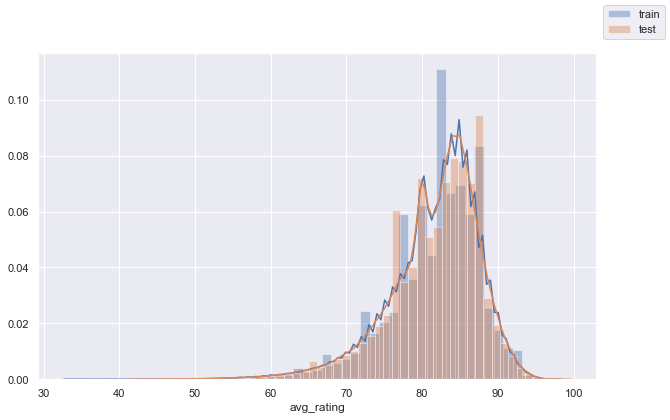

In [173]:
fig = plt.figure(figsize=(10,6))
sns.distplot(train['avg_rating'].dropna())
sns.distplot(test['avg_rating'].dropna())
fig.legend(labels=['train','test'])
plt.show()

The data distribution for the feature **avg_rating** is almost identical for the test set and the train set. Besides, the distribution is relatively close to a normal distribution where mean = median. We could use a median imputation for the missing values. But let's first remove outliers.

### 2.2. Outliers detection

#### 2.2.1. Z-Score

In [174]:
def zscore(series, threshold=3):
    z_score = (series-np.mean(series)) / np.std(series)
    return np.abs(z_score) > threshold

#### 2.2.2. Modified Z-Score

In [175]:
def modified_zscore(series, threshold=3):
    modified_z_score = 0.6745*(series-np.median(series))/series.mad()
    return np.abs(modified_z_score) > threshold

#### 2.2.3. Isolation Forest

In [176]:
from sklearn.ensemble import IsolationForest

In [177]:
def isolation_forest(series):
    clf = IsolationForest(behaviour='new', contamination='auto', random_state=0)
    series = series.values.reshape(-1, 1)
    clf.fit(series)
    return clf.predict(series)

#### Comparing outliers detection techniques

In [178]:
def get_proportion(series, inf, sup):
    return round((len(series[(series > inf) & (series < sup)]) / len(series))*100, 2)

In [179]:
def outlier_print(title, inliers, series):
    print('Outlier detection: {} identified outliers outside of the range [{}, {}]. Resulting outlier proportion: {}%.'.format(title, round(min(inliers)), round(max(inliers)), get_proportion(series, max(inliers), max(series)+1)))

In [180]:
def outliers_detection(series):
    inliers_zscore = series[~zscore(series)]
    outlier_print('Z-Score', inliers_zscore, series)
    inliers_modified_zscore = series[~modified_zscore(series)]
    outlier_print('Modified Z-Score', inliers_modified_zscore, series)
    inliers_isolation_forest = series[isolation_forest(series) == 1]
    outlier_print('Isolation Forest', inliers_isolation_forest, series)

In [181]:
train_numeric_columns = ['content_score', 'n_images', 'distance_to_center', 'avg_rating', 'n_reviews', 'avg_price', 'avg_saving_percent', 'n_clicks']
test_numeric_columns = ['content_score', 'n_images', 'distance_to_center', 'avg_rating', 'n_reviews', 'avg_price', 'avg_saving_percent']

In [182]:
train_without_missing_values = train.dropna()
test_without_missing_values = test.dropna()

In [183]:
print('Train set outliers detection:')
print('='*30)
for column in train_numeric_columns:
    print('⚀ Outlier detection for feature', column, ':\n')
    outliers_detection(train_without_missing_values[column])
    print('-'*120)

Train set outliers detection:
⚀ Outlier detection for feature content_score :

Outlier detection: Z-Score identified outliers outside of the range [28, 81]. Resulting outlier proportion: 0.0%.
Outlier detection: Modified Z-Score identified outliers outside of the range [28, 81]. Resulting outlier proportion: 0.0%.
Outlier detection: Isolation Forest identified outliers outside of the range [48, 63]. Resulting outlier proportion: 10.02%.
------------------------------------------------------------------------------------------------------------------------
⚀ Outlier detection for feature n_images :

Outlier detection: Z-Score identified outliers outside of the range [-1, 59672]. Resulting outlier proportion: 0.08%.
Outlier detection: Modified Z-Score identified outliers outside of the range [-1, 249]. Resulting outlier proportion: 0.09%.
Outlier detection: Isolation Forest identified outliers outside of the range [0, 3]. Resulting outlier proportion: 16.16%.
----------------------------

By definition, if there are too many outliers... they are not outliers. I use the outliers detection technique that is the most permissive : in this case it is Z-Score for every feature. I decide to drop the outliers when the proportion is < 1%.

In [184]:
def drop_outliers_zscore(df, column):
    inliers_zscore = df[column][~zscore(df[column])]
    min_inliers = round(min(inliers_zscore))
    max_inliers = round(max(inliers_zscore))
    outliers_proportion = get_proportion(df[column], max_inliers, max(df[column])+1)
    if outliers_proportion < 1:
        return df[(df[column] >= min_inliers) & (df[column] <= max_inliers)]
    else:
        return df

In [185]:
print('Dropping outliers where outliers proportion < 1% ...')
for column in train_numeric_columns:
    train_without_missing_values = drop_outliers_zscore(train_without_missing_values, column)

Dropping outliers where outliers proportion < 1% ...


In [186]:
print('Test set outliers detection:')
print('='*30)
for column in test_numeric_columns:
    print('⚀ Outlier detection for feature', column, ':\n')
    outliers_detection(test_without_missing_values[column])
    print('-'*120)

Test set outliers detection:
⚀ Outlier detection for feature content_score :

Outlier detection: Z-Score identified outliers outside of the range [28, 80]. Resulting outlier proportion: 0.0%.
Outlier detection: Modified Z-Score identified outliers outside of the range [27, 80]. Resulting outlier proportion: 0.0%.
Outlier detection: Isolation Forest identified outliers outside of the range [48, 63]. Resulting outlier proportion: 10.02%.
------------------------------------------------------------------------------------------------------------------------
⚀ Outlier detection for feature n_images :

Outlier detection: Z-Score identified outliers outside of the range [-1, 72686]. Resulting outlier proportion: 0.06%.
Outlier detection: Modified Z-Score identified outliers outside of the range [-1, 56]. Resulting outlier proportion: 0.1%.
Outlier detection: Isolation Forest identified outliers outside of the range [-1, 3]. Resulting outlier proportion: 15.86%.
------------------------------

In [187]:
print('Dropping outliers where outliers proportion < 1% ...')
for column in test_numeric_columns:
    test_without_missing_values = drop_outliers_zscore(test_without_missing_values, column)

Dropping outliers where outliers proportion < 1% ...


In [188]:
train_missing_values = train[train.isnull().any(axis=1)]
test_missing_values = test[test.isnull().any(axis=1)]

In [189]:
print('Before outliers removal, train set has',len(train),'rows.')
print('Before outliers removal, test set has',len(test),'rows.')

Before outliers removal, train set has 395760 rows.
Before outliers removal, test set has 131929 rows.


In [190]:
train = pd.concat([train_without_missing_values, train_missing_values])
test = pd.concat([test_without_missing_values, test_missing_values])

In [191]:
print('After outliers removal, train set has',len(train),'rows.')
print('After outliers removal, test set has',len(test),'rows.')

After outliers removal, train set has 382308 rows.
After outliers removal, test set has 127991 rows.


### 2.3. Missing values imputation

Now I will impute the missing values for the feature **avg_rating**. 
Let's have a look at the data distribution after outliers removal.

c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


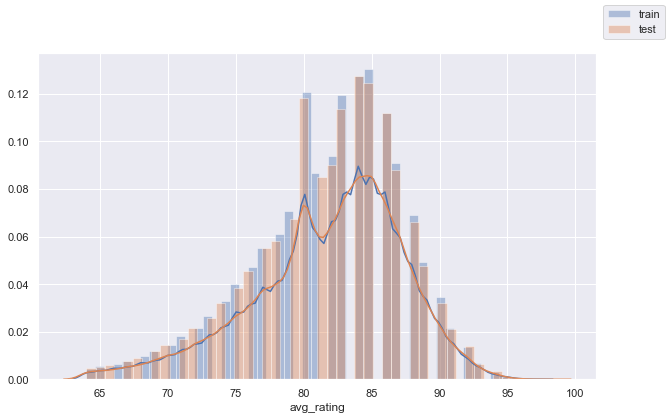

In [192]:
fig = plt.figure(figsize=(10,6))
sns.distplot(train['avg_rating'].dropna())
sns.distplot(test['avg_rating'].dropna())
fig.legend(labels=['train','test'])
plt.show()

For the imputation of missing values, I use k-Nearest Neighbors.

In [193]:
print('Missing values imputation using kNN...')
train = fast_knn(train, k=4)
test = fast_knn(test, k=4)
print('Done.')

Missing values imputation using kNN...


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\impyute\util\preprocess.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  args[0] = args[0].as_matrix()


Done.


In [194]:
train_columns = ['hotel_id', 'city_id', 'content_score', 'n_images', 'distance_to_center', 'avg_rating', 'stars', 'n_reviews', 'avg_rank', 'avg_price', 'avg_saving_percent', 'n_clicks']
test_columns = ['hotel_id', 'city_id', 'content_score', 'n_images', 'distance_to_center', 'avg_rating', 'stars', 'n_reviews', 'avg_rank', 'avg_price', 'avg_saving_percent']

In [195]:
train.columns = train_columns
test.columns = test_columns

In [196]:
train_columns = list(train.columns)
print('Train data set:\n')
for column in train_columns:
    print('All entries in train set have non-null', column ,':', ~train[column].isnull().any())
    
print('-'*100)

test_columns = list(test.columns)
print('Test data set:\n')
for column in test_columns:
    print('All entries in test set have non-null', column ,':', ~test[column].isnull().any())

Train data set:

All entries in train set have non-null hotel_id : True
All entries in train set have non-null city_id : True
All entries in train set have non-null content_score : True
All entries in train set have non-null n_images : True
All entries in train set have non-null distance_to_center : True
All entries in train set have non-null avg_rating : True
All entries in train set have non-null stars : True
All entries in train set have non-null n_reviews : True
All entries in train set have non-null avg_rank : True
All entries in train set have non-null avg_price : True
All entries in train set have non-null avg_saving_percent : True
All entries in train set have non-null n_clicks : True
----------------------------------------------------------------------------------------------------
Test data set:

All entries in test set have non-null hotel_id : True
All entries in test set have non-null city_id : True
All entries in test set have non-null content_score : True
All entries in 

No more missing values!

## 3. Exploratory data analysis
<a id="eda"></a>

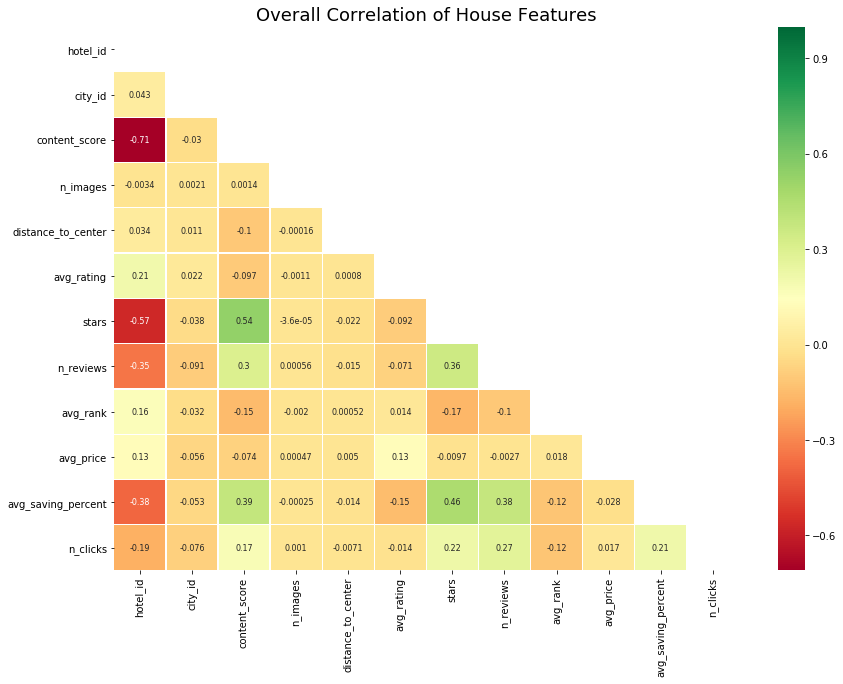

In [37]:
corr = train.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set-up figure
plt.figure(figsize=(14, 10))
# Title
plt.title('Overall Correlation of House Features', fontsize=18)
# Correlation matrix
sns.heatmap(corr, mask=mask, annot=True, annot_kws={"size":8}, cmap='RdYlGn', linewidths=0.2)
plt.show()

**n_reviews**, **stars**, **avg_saving_percent** and **content_score** are the features that are the most correlated to **n_clicks**.

### 3.1. Univariate analysis

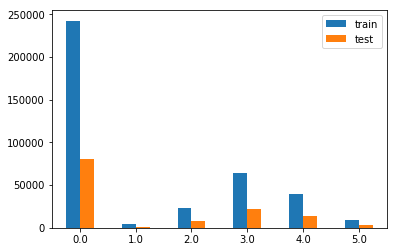

In [38]:
train_stars = train.groupby(['stars']).count()['hotel_id']
test_stars = test.groupby(['stars']).count()['hotel_id']
index = sorted(train.stars.unique())
pd.DataFrame({'train': train_stars, 'test': test_stars}, index=index).plot.bar(rot=0)

### 3.2. Bivariate analysis

c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


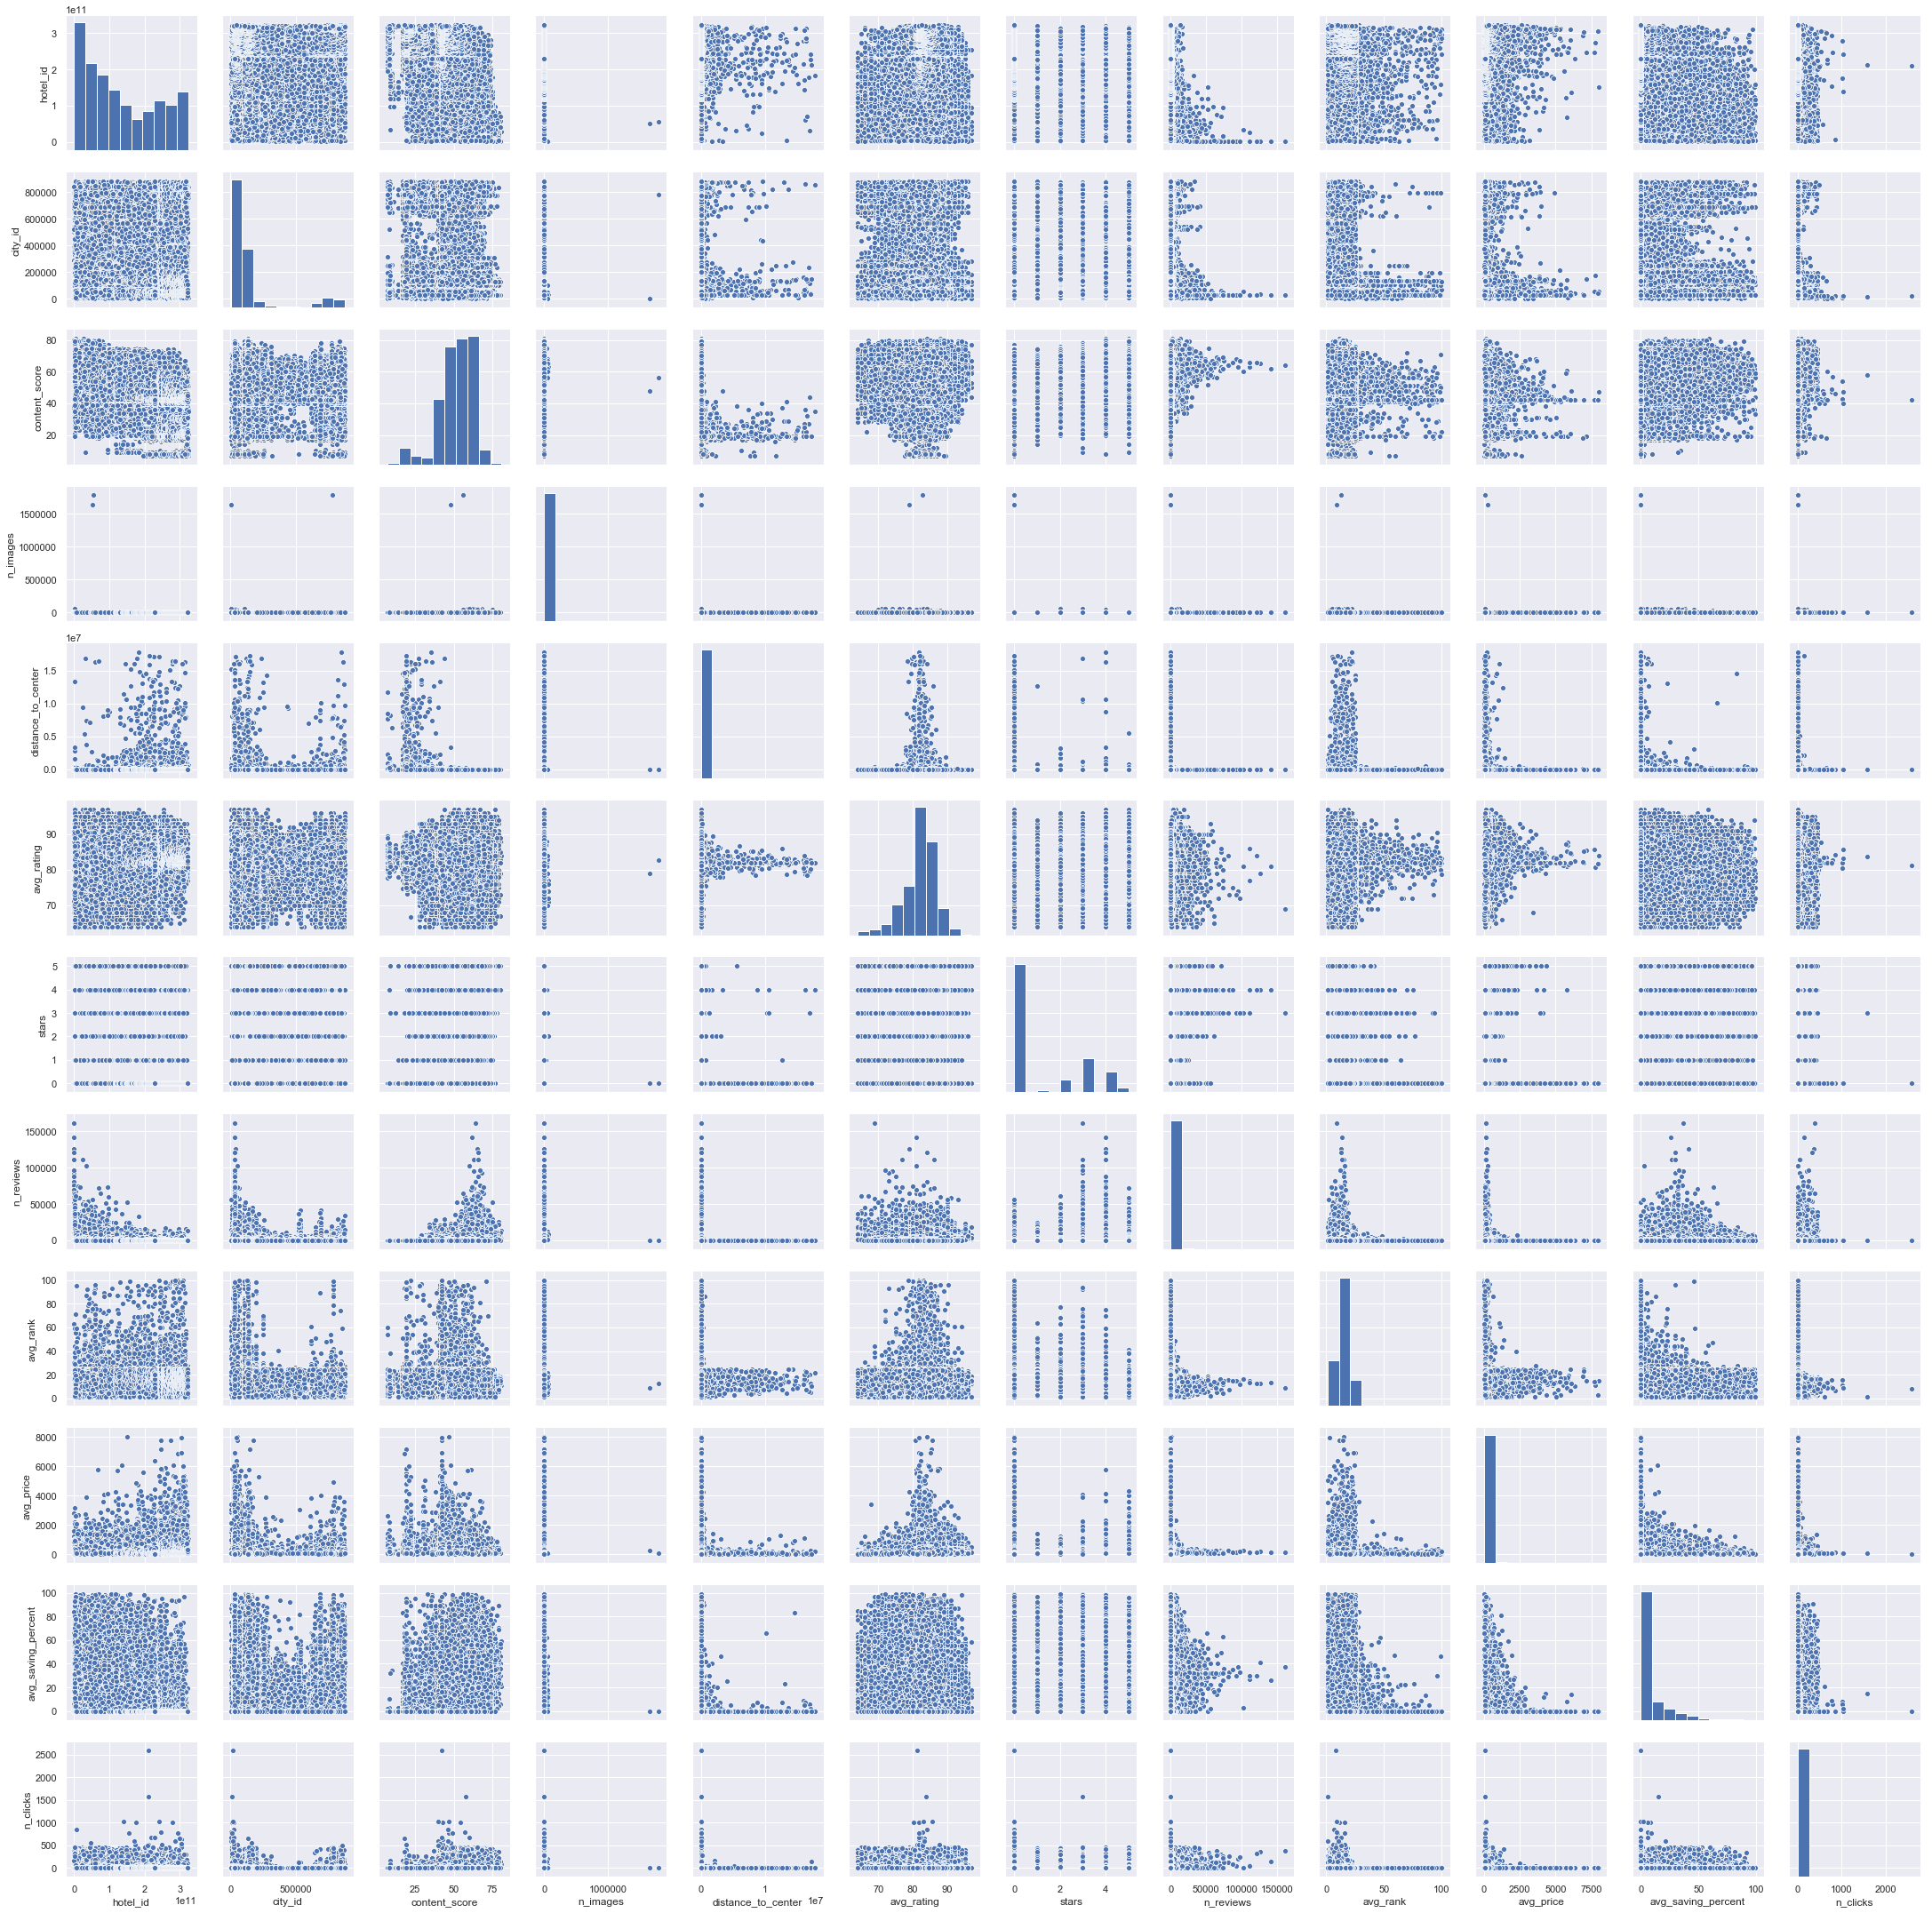

In [39]:
#scatterplot
sns.set()
columns = list(train.columns)
sns.pairplot(train[columns], size = 2.5)
plt.show();

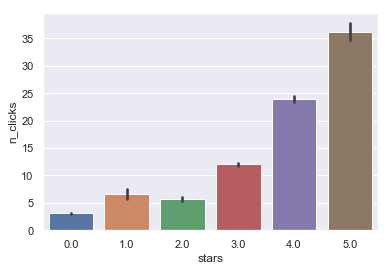

In [40]:
#Average n_clicks / stars
sns.barplot(x='stars', y='n_clicks', data=train)

## 4. Feature Selection

Initially, I wanted to use Extra Trees and Random Forest for feature selection. However, I don't have sufficient memory on my personal machine. Therefore, I decide to use Ridge.

In [41]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge

In [42]:
X, y = train.drop(columns=['hotel_id', 'n_clicks']), train['n_clicks']

ridge = Ridge(alpha=1.0)
ridge.fit(X,y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [43]:
feature_importance = pd.DataFrame({'feature': list(X.columns), 'ridge_coef': ridge.coef_})
feature_importance['ridge_coef'] = feature_importance['ridge_coef'].apply(lambda x: round(np.abs(x), 3))
feature_importance.sort_values('ridge_coef', ascending=False)

,feature,ridge_coef
5,stars,1.843
7,avg_rank,0.432
9,avg_saving_percent,0.210
4,avg_rating,0.154
1,content_score,0.081
8,avg_price,0.004
6,n_reviews,0.003
0,city_id,0.000
2,n_images,0.000
3,distance_to_center,0.000


I will use every feature from **stars** to **content_score** (included) for the predictive modeling. 

## 5. Prediction
<a id="pred"></a>

In [69]:
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders import OrdinalEncoder
from sklearn.metrics import make_scorer
from sklearn.base import clone

In [136]:
def nwmse(y_pred, y_obs):
    """ Norm Weighted Mean Squared Error """
    w_i = np.log(y_obs + 1) + 1
    w = np.sum(w_i)
    mse = np.sum(np.multiply(w_i, np.square(y_pred - y_obs)))
    score = mse / (w * len(y_obs))
    return score

In [137]:
models_scores = {}

### 5.1. Linear Regression

In [138]:
from sklearn.linear_model import LinearRegression

In [139]:
def linear_regression(df, n_folds):
    print('Model 1: Linear Regression')
    
    ordinal_features = ['stars']
    
    ordinal_transformer = Pipeline(steps=[
        ('ordenc', OrdinalEncoder()),
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('ord', ordinal_transformer, ordinal_features)])
    
    reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('linear_regression', LinearRegression())])
    
    X = df.drop(columns=['hotel_id', 'avg_price', 'n_reviews', 'city_id', 'n_images', 'distance_to_center', 'n_clicks'])
    y = df['n_clicks']
    
    
    kf = KFold(n_splits=n_folds)
    kf.get_n_splits(X)
    
    nwmse_kfold_train = []
    nwmse_kfold_test = []
    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        reg.fit(X_train, y_train)
        y_pred_train = reg.predict(X_train)
        y_pred_test = reg.predict(X_test)
        nwmse_kfold_train.append(nwmse(np.round(np.maximum(y_pred_train, 0)), np.array(y_train)))
        nwmse_kfold_test.append(nwmse(np.round(np.maximum(y_pred_test, 0)), np.array(y_test)))
        
    avg_nwmse_kfold_train = sum(nwmse_kfold_train) / len(nwmse_kfold_train)
    avg_nwmse_kfold_test = sum(nwmse_kfold_test) / len(nwmse_kfold_test)
    
    print('NWMSE train:', avg_nwmse_kfold_train)
    print('NWMSE test:', avg_nwmse_kfold_test)
    
    return avg_nwmse_kfold_test    

In [140]:
models_scores['model_1'] = linear_regression(train, 5)

Model 1: Linear Regression
NWMSE train: 0.011868964704850434
NWMSE test: 0.04493660840306972


### 5.2. Decision Tree

In [141]:
from sklearn.tree import DecisionTreeRegressor

In [142]:
def decision_tree(df, n_folds):
    print('Model 2: Decision Tree (GridSearch)')
    
    ordinal_categories = ['stars']
    
    categorical_transformer = Pipeline(steps=[
    ('ordenc', OrdinalEncoder())])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, ordinal_categories)])
    
    model  = Pipeline(steps=[('preprocessor', preprocessor),
                      ('decision_tree', DecisionTreeRegressor(random_state=0))])
    
    X = df.drop(columns=['hotel_id', 'avg_price', 'n_reviews', 'city_id', 'n_images', 'distance_to_center', 'n_clicks'])
    y = df['n_clicks']
    
    nwmse_scorer = make_scorer(nwmse, greater_is_better=False)
    
    num_leafs = [10, 20, 50, 100, 200]
    depths = [10, 15]
    
    param_grid = [{'decision_tree__max_depth': depths,
              'decision_tree__min_samples_leaf':num_leafs}]
    
    
    grid = GridSearchCV(model, param_grid, cv=10, scoring=nwmse_scorer, iid=False, return_train_score=True, error_score=np.nan, n_jobs=1, verbose=1)
    grid.fit(X, y)
    print('Best Parameters:', grid.best_params_)
    best_model = clone(grid.best_estimator_)
    
    kf = KFold(n_splits=n_folds)
    kf.get_n_splits(X)
    
    nwmse_kfold_train = []
    nwmse_kfold_test = []
    for train_index, test_index in kf.split(X,y):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        best_model.fit(X_train, y_train)
        y_pred_test = best_model.predict(X_test)
        y_pred_train = best_model.predict(X_train)
        nwmse_kfold_train.append(nwmse(np.round(np.maximum(y_pred_train, 0)), y_train))
        nwmse_kfold_test.append(nwmse(np.round(np.maximum(y_pred_test, 0)), y_test))
        
        
    
    avg_nwmse_kfold_train = sum(nwmse_kfold_train) / len(nwmse_kfold_train)
    avg_nwmse_kfold_test = sum(nwmse_kfold_test) / len(nwmse_kfold_test)
    
    print('NWMSE train:', avg_nwmse_kfold_train)
    print('NWMSE test:', avg_nwmse_kfold_test)
    
    return avg_nwmse_kfold_test  

In [143]:
models_scores['model_2'] = decision_tree(train, 5)

Model 2: Decision Tree (GridSearch)
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.2min finished


Best Parameters: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_leaf': 10}
NWMSE train: 0.01172557581001105
NWMSE test: 0.04445538588302917


### 5.3. Random Forest

In [144]:
from sklearn.ensemble import RandomForestRegressor

In [145]:
def random_forest(df, n_folds):
    print('Model 3: Random Forest (RandomSearch)')
    
    ordinal_categories = ['stars']
    
    categorical_transformer = Pipeline(steps=[
    ('ordenc', OrdinalEncoder())])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, ordinal_categories)])
    
    model  = Pipeline(steps=[('preprocessor', preprocessor),
                      ('random_forest', RandomForestRegressor(random_state=0))])
    
    X = df.drop(columns=['hotel_id', 'avg_price', 'n_reviews', 'city_id', 'n_images', 'distance_to_center', 'n_clicks'])
    y = df['n_clicks']
    
    nwmse_scorer = make_scorer(nwmse, greater_is_better=False)
    
    param_dist = {
        'random_forest__n_estimators': [50],
        'random_forest__max_features': ['sqrt', 'log2'],
        'random_forest__max_depth': [4, 10, 15],
    }
    
    kf = KFold(n_splits=n_folds)
    kf.get_n_splits(X)
    
    rnd_search = RandomizedSearchCV(model, param_dist, n_iter=5, cv=kf, scoring=nwmse_scorer, iid=False, return_train_score=True, error_score=np.nan, n_jobs=1, random_state=0, verbose=10)
    rnd_search.fit(X, y)
    print('Best Parameters:', rnd_search.best_params_)
    best_model = clone(rnd_search.best_estimator_)
    
    
    
    nwmse_kfold_train = []
    nwmse_kfold_test = []
    for train_index, test_index in kf.split(X,y):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        best_model.fit(X_train, y_train)
        y_pred_test = best_model.predict(X_test)
        y_pred_train = best_model.predict(X_train)
        nwmse_kfold_train.append(nwmse(np.round(np.maximum(y_pred_train, 0)), y_train))
        nwmse_kfold_test.append(nwmse(np.round(np.maximum(y_pred_test, 0)), y_test))
        
        
    
    avg_nwmse_kfold_train = sum(nwmse_kfold_train) / len(nwmse_kfold_train)
    avg_nwmse_kfold_test = sum(nwmse_kfold_test) / len(nwmse_kfold_test)
    
    print('NWMSE train:', avg_nwmse_kfold_train)
    print('NWMSE test:', avg_nwmse_kfold_test)
    
    return avg_nwmse_kfold_test  

In [146]:
models_scores['model_3'] = random_forest(train, 5)

Model 3: Random Forest (RandomSearch)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] random_forest__n_estimators=50, random_forest__max_features=log2, random_forest__max_depth=15 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  random_forest__n_estimators=50, random_forest__max_features=log2, random_forest__max_depth=15, score=-0.024016211961303432, total=   3.1s
[CV] random_forest__n_estimators=50, random_forest__max_features=log2, random_forest__max_depth=15 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s


[CV]  random_forest__n_estimators=50, random_forest__max_features=log2, random_forest__max_depth=15, score=-0.024227442123450415, total=   3.2s
[CV] random_forest__n_estimators=50, random_forest__max_features=log2, random_forest__max_depth=15 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.3s remaining:    0.0s


[CV]  random_forest__n_estimators=50, random_forest__max_features=log2, random_forest__max_depth=15, score=-0.019260775885616484, total=   3.0s
[CV] random_forest__n_estimators=50, random_forest__max_features=log2, random_forest__max_depth=15 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s


[CV]  random_forest__n_estimators=50, random_forest__max_features=log2, random_forest__max_depth=15, score=-0.008364775802059351, total=   3.6s
[CV] random_forest__n_estimators=50, random_forest__max_features=log2, random_forest__max_depth=15 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   28.4s remaining:    0.0s


[CV]  random_forest__n_estimators=50, random_forest__max_features=log2, random_forest__max_depth=15, score=-0.004482073529454769, total=   3.3s
[CV] random_forest__n_estimators=50, random_forest__max_features=sqrt, random_forest__max_depth=10 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.9s remaining:    0.0s


[CV]  random_forest__n_estimators=50, random_forest__max_features=sqrt, random_forest__max_depth=10, score=-0.024016211961303432, total=   3.3s
[CV] random_forest__n_estimators=50, random_forest__max_features=sqrt, random_forest__max_depth=10 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   42.9s remaining:    0.0s


[CV]  random_forest__n_estimators=50, random_forest__max_features=sqrt, random_forest__max_depth=10, score=-0.024227442123450415, total=   3.2s
[CV] random_forest__n_estimators=50, random_forest__max_features=sqrt, random_forest__max_depth=10 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   50.0s remaining:    0.0s


[CV]  random_forest__n_estimators=50, random_forest__max_features=sqrt, random_forest__max_depth=10, score=-0.019260775885616484, total=   3.2s
[CV] random_forest__n_estimators=50, random_forest__max_features=sqrt, random_forest__max_depth=10 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   57.2s remaining:    0.0s


[CV]  random_forest__n_estimators=50, random_forest__max_features=sqrt, random_forest__max_depth=10, score=-0.008364775802059351, total=   3.2s
[CV] random_forest__n_estimators=50, random_forest__max_features=sqrt, random_forest__max_depth=10 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.1min remaining:    0.0s


[CV]  random_forest__n_estimators=50, random_forest__max_features=sqrt, random_forest__max_depth=10, score=-0.004482073529454769, total=   3.2s
[CV] random_forest__n_estimators=50, random_forest__max_features=log2, random_forest__max_depth=4 
[CV]  random_forest__n_estimators=50, random_forest__max_features=log2, random_forest__max_depth=4, score=-0.024016211961303432, total=   3.1s
[CV] random_forest__n_estimators=50, random_forest__max_features=log2, random_forest__max_depth=4 
[CV]  random_forest__n_estimators=50, random_forest__max_features=log2, random_forest__max_depth=4, score=-0.024227442123450415, total=   3.1s
[CV] random_forest__n_estimators=50, random_forest__max_features=log2, random_forest__max_depth=4 
[CV]  random_forest__n_estimators=50, random_forest__max_features=log2, random_forest__max_depth=4, score=-0.019260775885616484, total=   3.2s
[CV] random_forest__n_estimators=50, random_forest__max_features=log2, random_forest__max_depth=4 
[CV]  random_forest__n_estimato

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.0min finished


Best Parameters: {'random_forest__n_estimators': 50, 'random_forest__max_features': 'log2', 'random_forest__max_depth': 15}
NWMSE train: 0.01172557581001105
NWMSE test: 0.04445538588302917


### 5.4. Extra Trees

In [147]:
from sklearn.ensemble import ExtraTreesRegressor

In [148]:
def extra_trees(df, n_folds):
    print('Model 4: Extra Trees (RandomSearch)')
    
    ordinal_categories = ['stars']
    
    categorical_transformer = Pipeline(steps=[
    ('ordenc', OrdinalEncoder())])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, ordinal_categories)])
    
    model  = Pipeline(steps=[('preprocessor', preprocessor),
                      ('extra_trees', ExtraTreesRegressor(random_state=0))])
    
    X = df.drop(columns=['hotel_id', 'avg_price', 'n_reviews', 'city_id', 'n_images', 'distance_to_center', 'n_clicks'])
    y = df['n_clicks']
    
    nwmse_scorer = make_scorer(nwmse, greater_is_better=False)
    
    param_dist = {
        'extra_trees__n_estimators': [50],
        'extra_trees__max_features': ['sqrt', 'log2'],
        'extra_trees__max_depth': [4, 10, 15],
    }
    
    kf = KFold(n_splits=n_folds)
    kf.get_n_splits(X)
    
    rnd_search = RandomizedSearchCV(model, param_dist, n_iter=5, cv=kf, scoring=nwmse_scorer, iid=False, return_train_score=True, error_score=np.nan, n_jobs=1, random_state=0, verbose=1)
    rnd_search.fit(X, y)
    print('Best Parameters:', rnd_search.best_params_)
    best_model = clone(rnd_search.best_estimator_)
    
    
    
    nwmse_kfold_train = []
    nwmse_kfold_test = []
    for train_index, test_index in kf.split(X,y):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        best_model.fit(X_train, y_train)
        y_pred_test = best_model.predict(X_test)
        y_pred_train = best_model.predict(X_train)
        nwmse_kfold_train.append(nwmse(np.round(np.maximum(y_pred_train, 0)), y_train))
        nwmse_kfold_test.append(nwmse(np.round(np.maximum(y_pred_test, 0)), y_test))
        
        
    
    avg_nwmse_kfold_train = sum(nwmse_kfold_train) / len(nwmse_kfold_train)
    avg_nwmse_kfold_test = sum(nwmse_kfold_test) / len(nwmse_kfold_test)
    
    print('NWMSE train:', avg_nwmse_kfold_train)
    print('NWMSE test:', avg_nwmse_kfold_test)
    
    return avg_nwmse_kfold_test  

In [149]:
models_scores['model_4'] = extra_trees(train, 5)

Model 4: Extra Trees (RandomSearch)
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.8min finished


Best Parameters: {'extra_trees__n_estimators': 50, 'extra_trees__max_features': 'log2', 'extra_trees__max_depth': 4}
NWMSE train: 0.011739767108559765
NWMSE test: 0.04452171676877876


### 5.5. XGBoost

In [150]:
import xgboost as xgb

In [151]:
def xgboost(df, n_folds):
    print('Model 5: XGBoost (RandomSearch)')
    
    ordinal_categories = ['stars']
    
    categorical_transformer = Pipeline(steps=[
    ('ordenc', OrdinalEncoder())])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, ordinal_categories)])
    
    model  = Pipeline(steps=[('preprocessor', preprocessor),
                      ('xgboost', xgb.XGBRegressor())])
    
    X = df.drop(columns=['hotel_id', 'avg_price', 'n_reviews', 'city_id', 'n_images', 'distance_to_center', 'n_clicks'])
    y = df['n_clicks']
    
    nwmse_scorer = make_scorer(nwmse, greater_is_better=False)
    
    param_dist = {
        'xgboost__min_child_weight': [1, 5],
        'xgboost__gamma': [0.5, 1, 1.5, 2, 5],
        'xgboost__subsample': [0.6, 0.8, 1.0],
        'xgboost__colsample_bytree': [0.6, 0.8, 1.0],
        'xgboost__max_depth': [3, 4, 5]
    }
    
    kf = KFold(n_splits=n_folds)
    kf.get_n_splits(X)
    
    rnd_search = RandomizedSearchCV(model, param_dist, n_iter=5, cv=kf, scoring=nwmse_scorer, iid=False, return_train_score=True, error_score=np.nan, n_jobs=1, random_state=0, verbose=1)
    rnd_search.fit(X, y)
    print('Best Parameters:', rnd_search.best_params_)
    best_model = clone(rnd_search.best_estimator_)
    
    
    
    nwmse_kfold_train = []
    nwmse_kfold_test = []
    for train_index, test_index in kf.split(X,y):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        best_model.fit(X_train, y_train)
        y_pred_test = best_model.predict(X_test)
        y_pred_train = best_model.predict(X_train)
        nwmse_kfold_train.append(nwmse(np.round(np.maximum(y_pred_train, 0)), y_train))
        nwmse_kfold_test.append(nwmse(np.round(np.maximum(y_pred_test, 0)), y_test))
        
        
    
    avg_nwmse_kfold_train = sum(nwmse_kfold_train) / len(nwmse_kfold_train)
    avg_nwmse_kfold_test = sum(nwmse_kfold_test) / len(nwmse_kfold_test)
    
    print('NWMSE train:', avg_nwmse_kfold_train)
    print('NWMSE test:', avg_nwmse_kfold_test)
    
    return avg_nwmse_kfold_test  

In [152]:
models_scores['model_5'] = xgboost(train, 5)

Model 5: XGBoost (RandomSearch)
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:28:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:30:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:30:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:30:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:22] WARNI

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  9.0min finished
c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:37:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best Parameters: {'xgboost__subsample': 0.8, 'xgboost__min_child_weight': 5, 'xgboost__max_depth': 4, 'xgboost__gamma': 2, 'xgboost__colsample_bytree': 0.6}
[11:38:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:38:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:38:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:38:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:39:08] WARNING: C:/

## 6. Evaluation
<a id="eval"></a>

In [156]:
scores = [tup[1] for tup in sorted(models_scores.items(), key=lambda key_value: key_value[0])]

In [157]:
models = ["Linear Regression", 
          "Decision Tree", 
          "Random Forest",
          "Extra Trees",
          "XGBoost",
         ]

pd.DataFrame({"Model":models, "Score":scores}).sort_values("Score", ascending=True)

,Model,Score
1,Decision Tree,0.044455
2,Random Forest,0.044455
4,XGBoost,0.044455
3,Extra Trees,0.044522
0,Linear Regression,0.044937


In [197]:
def best_model(train, test):
    print('Predicting test clicks.')
    categorical_features = ['stars']
    
    categorical_transformer = Pipeline(steps=[
    ('ordenc', OrdinalEncoder())])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)])
    
    model  = Pipeline(steps=[('preprocessor', preprocessor),
                      ('decision_tree', DecisionTreeRegressor(max_depth=10, min_samples_leaf=10))])
    
    X_train = train.drop(columns=['hotel_id', 'avg_price', 'n_reviews', 'city_id', 'n_images', 'distance_to_center', 'n_clicks'])
    y_train = train['n_clicks']
    
    X_test = test.drop(columns=['hotel_id', 'avg_price', 'n_reviews', 'city_id', 'n_images', 'distance_to_center'])
    
    model.fit(X_train, y_train)
    y_test = model.predict(X_test)
    
    test['n_clicks'] = np.round(np.maximum(y_test, 0))

    return test[['hotel_id', 'n_clicks']]

In [198]:
y_pred = best_model(train, test)

Predicting test clicks.


In [199]:
y_pred.head()

,hotel_id,n_clicks
0,1.494226e+10,3.0
1,1.603604e+10,36.0
2,1.290416e+11,3.0
3,1.246030e+10,12.0
4,6.847922e+10,7.0


In [200]:
y_pred.to_csv('datasets/clicks_prediction.csv')